In [292]:
with open(os.path.join(data_dir_path, 'raw', 'pdbbind_general_conf_ensemble_library.p'), 'rb') as f :
    refined_CEL = pickle.load(f)

In [301]:
rdkit_mol = list(refined_CEL.get_unique_molecules())[1][1].mol

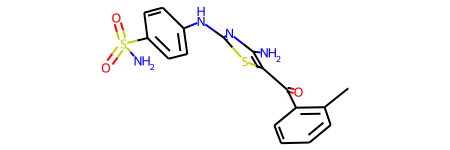

In [302]:
rdkit_mol

In [303]:
def ccdc_conformers_to_rdkit_mol(rdkit_mol, ccdc_conformers, exclude_hydrogens=True) :

    generated_conf_ids = []
    for conformer in ccdc_conformers :
        temp_rdkit_mol = copy.deepcopy(rdkit_mol)
        new_rdkit_conf = temp_rdkit_mol.GetConformer()
        ccdc_conformer_atoms = conformer.molecule.atoms
        if exclude_hydrogens :
            # conformer_ccdc_molecule.remove_hydrogens() # doesnt work
            ccdc_conformer_atoms = [atom for atom in ccdc_conformer_atoms if atom.atomic_symbol != 'H']
        for i, atom in enumerate(ccdc_conformer_atoms) :
            atom_coord = [coord for coord in atom.coordinates]
            point3d = Point3D(*atom_coord)
            new_rdkit_conf.SetAtomPosition(i, point3d)
        conf_id = rdkit_mol.AddConformer(new_rdkit_conf, assignId=True)
        generated_conf_ids.append(conf_id)
        
    return generated_conf_ids

In [304]:
torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(rdkit_mol)[0]]

In [305]:
bioactive_conf_ids = [conf.GetId() for conf in rdkit_mol.GetConformers()]
n_bioactive_confs = len(bioactive_conf_ids)

ccdc_conformer_generator = ConformerGenerator(nthreads=8)

n_conf_to_generate = int((50 - n_bioactive_confs) / (n_bioactive_confs + 1))

mol2_block = Chem.MolToMolBlock(rdkit_mol)
            
ccdc_mol = Molecule.from_string(mol2_block)
ccdc_conformer_generator.settings.max_conformers = n_conf_to_generate
ccdc_conformers = ccdc_conformer_generator.generate(ccdc_mol)

generated_conf_ids = ccdc_conformers_to_rdkit_mol(rdkit_mol, ccdc_conformers, exclude_hydrogens=True)

torsion_values = defaultdict(list)
for bioactive_conf_id in bioactive_conf_ids :
    bioactive_conf = rdkit_mol.GetConformer(bioactive_conf_id)
    for generated_conf_id in generated_conf_ids :
        generated_conf = rdkit_mol.GetConformer(generated_conf_id)
        
        dummy_mol = copy.deepcopy(rdkit_mol)
        new_conf = dummy_mol.GetConformer()
        for torsion_atoms in torsions :
            bioactive_dihedral = GetDihedralDeg(bioactive_conf, *torsion_atoms)
            generated_dihedral = GetDihedralDeg(generated_conf, *torsion_atoms)
            interpolated_dihedral = angle_interpolation(bioactive_dihedral, generated_dihedral)
            
            SetDihedralDeg(new_conf, *torsion_atoms, interpolated_dihedral[0])
            
        rdkit_mol.AddConformer(new_conf, assignId=True)

INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul
INFO: /home/benoit/CCDC/CSD_2021/bin/mogul


In [307]:
n_conf_to_generate

24

In [298]:
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
import py3Dmol

def MolTo3DView(mol, confId=-1, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol, confId=confId)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def conf_viewer(idx):
    return MolTo3DView(rdkit_mol, idx).show()

interact(conf_viewer, idx=ipywidgets.IntSlider(min=0,max=rdkit_mol.GetNumConformers() - 1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=49), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>

In [212]:
from ccdc.conformer import GeometryAnalyser
from ccdc.descriptors import MolecularDescriptors

mol2_block = Chem.MolToMolBlock(rdkit_mol)
for angle in range(360) :
    ccdc_mol = Molecule.from_string(mol2_block)
    torsion_atoms = [atom for i, atom in enumerate(ccdc_mol.atoms) if i in torsion_atom_ids]
    ccdc_mol.set_torsion_angle(*torsion_atoms, angle)
    
    ga = GeometryAnalyser()
    anal = ga.analyse_torsion(*torsion_atoms)
    #print(int(anal.value))
    print(MolecularDescriptors.overlay_rmsds_and_transformation(ccdc_mol, Molecule.from_string(mol2_block))[1])
    
    temp_rdkit_mol = copy.deepcopy(rdkit_mol)
    new_rdkit_conf = temp_rdkit_mol.GetConformer()
    ccdc_conformer_atoms = ccdc_mol.atoms
    for i, atom in enumerate(ccdc_conformer_atoms) :
        atom_coord = [coord for coord in atom.coordinates]
        point3d = Point3D(*atom_coord)
        new_rdkit_conf.SetAtomPosition(i, point3d)
    rdkit_mol.AddConformer(new_rdkit_conf, assignId=True)

0.17792808289207
0.1914294681518079
0.20495756073851257
0.21851165098434844
0.2320910082873799
0.24569488103640189
0.25932249653967465
0.27297306095748786
0.2866457592384576
0.3003397550594691
0.3140541907691996
0.327788187335123
0.3415408442939277
0.3553112397052766
0.3690984301088412
0.3829014504845258
0.39671931421584816
0.41055101305637814
0.42439551709922757
0.4382517747494953
0.4521187126996411
0.4659952359077586
0.47988022757868765
0.4937725491479498
0.5076710402684815
0.5215745188001402
0.5354817808019798
0.5493916005272809
0.5633027304213492
0.5772139011220858
0.5911238214633376
0.6050311784810897
0.618934637422493
0.6328328417578019
0.6467244131952716
0.6606079516990916
0.6744820355104111
0.6883452211715817
0.7021960435537014
0.7160330158875914
0.7298546297983198
0.7436593553434738
0.7574456410552731
0.7712119139867769
0.7849565797623587
0.7986780226326681
0.8123746055343374
0.8260446701546917
0.8396865370017523
0.8532985054798601
0.8668788539712273
0.8804258399238223
0.89393

In [230]:
from rdkit.Chem.Draw import rdMolDraw2D
d = rdMolDraw2D.MolDraw2DCairo(1000, 1000)
d.drawOptions().addStereoAnnotation = True
d.drawOptions().addAtomIndices = True
d.DrawMolecule(rdkit_mol)
d.FinishDrawing()
d.WriteDrawingText('atom_annotation_1.png') 

In [279]:
def angle_interpolation(start, end, amounts=[0.5]) :
    interps = []
    for amount in amounts :
        shortest_angle = ((((end - start) % 360) + 540) % 360) - 180
        to_add = shortest_angle * amount
        interps.append((((start + to_add) + 180) % 360) - 180)
    return interps

In [236]:
torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(rdkit_mol)[0]]

In [280]:
from rdkit.Chem.rdMolTransforms import GetDihedralDeg, SetDihedralDeg
from collections import defaultdict

torsion_values = defaultdict(list)
for conf in rdkit_mol.GetConformers() :
    for torsion_atoms in torsions :
        dihedral = GetDihedralDeg(conf, *torsion_atoms)
        torsion_values[torsion_atoms].append(int(dihedral))
        
torsion_interpolated = {}
for atoms, values in torsion_values.items() :
    min_angle = min(values)
    max_angle = max(values)
    torsion_interpolated[atoms] = angle_interpolation(min_angle, max_angle)

In [281]:
torsion_interpolated

{(4, 7, 8, 9): [142.5],
 (7, 8, 9, 10): [1.5],
 (10, 9, 11, 12): [-179.5],
 (14, 21, 22, 25): [179.5],
 (29, 26, 27, 28): [-165.0],
 (24, 29, 30, 31): [22.0]}